In [1]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 4.6 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

plt.rcParams.update({'font.size': 14})

In [3]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(20, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(50, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")


def make_synthesis_transform(patch_size):
  """Creates the synthesis (decoder) transform."""
  if (patch_size // 4) * 4 != patch_size:
    raise ValueError('patch_size must be dividable ny 4!')

  return tf.keras.Sequential([
      tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(50 * (patch_size//4)**2, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((patch_size//4, patch_size//4, 50)),
      tf.keras.layers.Conv2DTranspose(20, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(1, 5, use_bias=True, strides=2, padding="same", activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

In [4]:
class DASCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for DAS data."""

  def __init__(self, latent_dims, patch_size):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform(patch_size)
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).

    # Note: since x is devided by 255, we need mutiply the 
    # original data by 255 to keep consistency in data preparation
    x = tf.cast(x, self.compute_dtype) / 255.

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))

    return dict(rate=rate, distortion=distortion)


In [5]:
def extract_image_patches(DAS_data, patch_size):
  ''' Divide the DAS data (channels by time samples) into small
      patches with the size of patch_size

        Parameters
        ----------
        DAS_data : numpy array (channels by time samples)
        patch_size : int, size of the patch
        
        Returns
        -------
        patches : list of patches
        factors : list of factors used in patch normalization
  '''

  height, width, = DAS_data.shape

  patches = []
  factors = []
  for y in range(0, height - patch_size + 1, patch_size):
    for x in range(0, width - patch_size + 1, patch_size):

      # extract the patch
      patch = DAS_data[y:y + patch_size, x:x + patch_size]
        
      # post-process the patch
      patch = patch.reshape(patch_size, patch_size, 1)
      patch.astype(np.float32)

      # normalize the patch by to the scale of 255 (consistent with the code)
      norm_factor = 1.0 / np.max(abs(patch)) * 255
      patch = patch * norm_factor
      patch[patch == np.nan] = 0.0

    
      # append
      factors.append(norm_factor)
      patches.append(patch)

  return patches, factors


def prepare_das_dataset(data_list, train_ratio = 0.8, shuffle = True):
  ''' Split the data into training and validation sets

        Parameters  
        ----------
        data_list : list
            list of data
        train_ratio : float
            ratio of training data
        shuffle: boolean
            shuffle or not
        
        Returns
        -------
        training_dataset : tf.data.Dataset
            training dataset
        validation_dataset : tf.data.Dataset
            validation dataset          
  '''
  
  # Shuffle the data randomly (we can also do this using TensorFlow feature)
  if shuffle == True:
    random.shuffle(data_list)

  # Calculate the split index based on the train_ratio
  split_index = int(len(data_list) * train_ratio)

  # Split the data into training and validation sets
  train_data = data_list[:split_index]
  validation_data = data_list[split_index:]
  
  # Convert the Python lists to TensorFlow tensors
  train_data = tf.convert_to_tensor(train_data, dtype=tf.float32)
  validation_data = tf.convert_to_tensor(validation_data, dtype=tf.float32)

  # Create TensorFlow datasets (the label is the same as the input)
  training_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
  validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_data))

  return training_dataset, validation_dataset


def reconstruct_image_from_patches(patches, factors, original_shape, patch_size):
    ''' Reconstruct the original image from patches.

        Parameters
        ----------
        patches : list of patches
        original_shape : tuple, shape of the original image (channels, time samples)
        patch_size : int, size of the patch
        factors : list of factors used in patch normalization

        Returns
        -------
        reconstructed_image : numpy array, the reconstructed image
    '''

    height, width = original_shape

    reconstructed_image = np.zeros(original_shape)

    patch_index = 0
    for y in range(0, height - patch_size + 1, patch_size):
        for x in range(0, width - patch_size + 1, patch_size):

            # get the patch
            patch = patches[patch_index]
            patch = np.reshape(patch, (patch_size, patch_size))

            # restore the normalization
            patch = patch / factors[patch_index]
            patch[patch==np.nan] = 0.0

            # put the patch back to where it belongs to
            reconstructed_image[y:y + patch_size, x:x + patch_size] = patch
            patch_index += 1

    return reconstructed_image


In [6]:
class DASCompressor(tf.keras.Model):
  """Compresses DAS data to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits


class DASDecompressor(tf.keras.Model):
  """Decompresses DAS data from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.float32)


In [7]:
def make_das_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.

  entropy_model = tfc.ContinuousBatchedEntropyModel(trainer.prior, coding_rank=1, compression=True, **kwargs)
  # compressor = DASCompressor(trainer.analysis_transform, entropy_model)
  decompressor = DASDecompressor(entropy_model, trainer.synthesis_transform)
  
  return None, decompressor

In [8]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x


def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)


def train_das_model(lmbda=2000,          # weight for rate–distortion Lagrangian
                    latent_dims=50,      # layers in latent space
                    patch_size = 28,     # patch size of the image, must be dividable by 4
                    epochs=15,           # epoch
                    batch_size=128,      # batch size
                    learning_rate=1e-3,  # learning rate
                    validation_freq=1,   # validation freq
                    ):

  trainer = DASCompressionTrainer(latent_dims, patch_size)
  trainer.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      # Just pass through rate and distortion as losses/metrics.
      loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
      metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
      loss_weights=dict(rate=1., distortion=lmbda),)

  return trainer

In [9]:
# load my google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
patch_size = 32

trainer = train_das_model(
                    lmbda=2000,                # weight for rate–distortion Lagrangian
                    latent_dims=100,            # layers in latent space
                    patch_size = patch_size,   # patch size of the image, must be dividable by 4
                    epochs=100,                # epoch
                    batch_size=128,            # batch size
                    learning_rate=1e-3,        # learning rate
                    validation_freq=1,)        # validation freq


# load the model
trainer.load_weights("./drive/MyDrive/Training Dataset/das_compression_model_%d"%(patch_size))

In [11]:
# define compressor and decompressor
compressor, decompressor = make_das_codec(trainer)

In [12]:
# load compressed string data 
string_np = np.load('./drive/MyDrive/Training Dataset/strings.npy', allow_pickle=True)
strings = tf.convert_to_tensor(string_np)

# load normlazation factor
factors = np.load('./drive/MyDrive/Training Dataset/factors.npy')

In [13]:
# Decompress the images back from the strings.
patches_decompre = decompressor(strings)

In [14]:
original_shape = (4800, 3000)
decompre_das = reconstruct_image_from_patches(patches_decompre, factors, original_shape, patch_size)

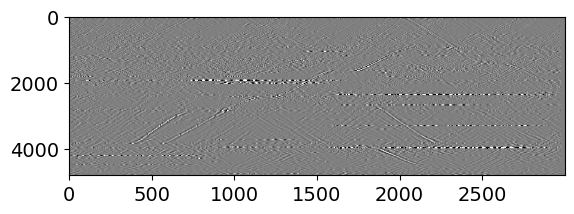

In [15]:
pclip = np.percentile(decompre_das, 99.)
plt.imshow(decompre_das, cmap='gray', aspect=0.2, vmin=-pclip, vmax=pclip)

In [16]:
file_test = ['./drive/MyDrive/Training Dataset/effective_dataset/smcity_rwc_nc4800_ch37500-42300_nt3000_sf5_bp0.08-2_D2022-10-26_T00-37-56_p10min.npz']
original_das = np.load(file_test[0])['pdata']

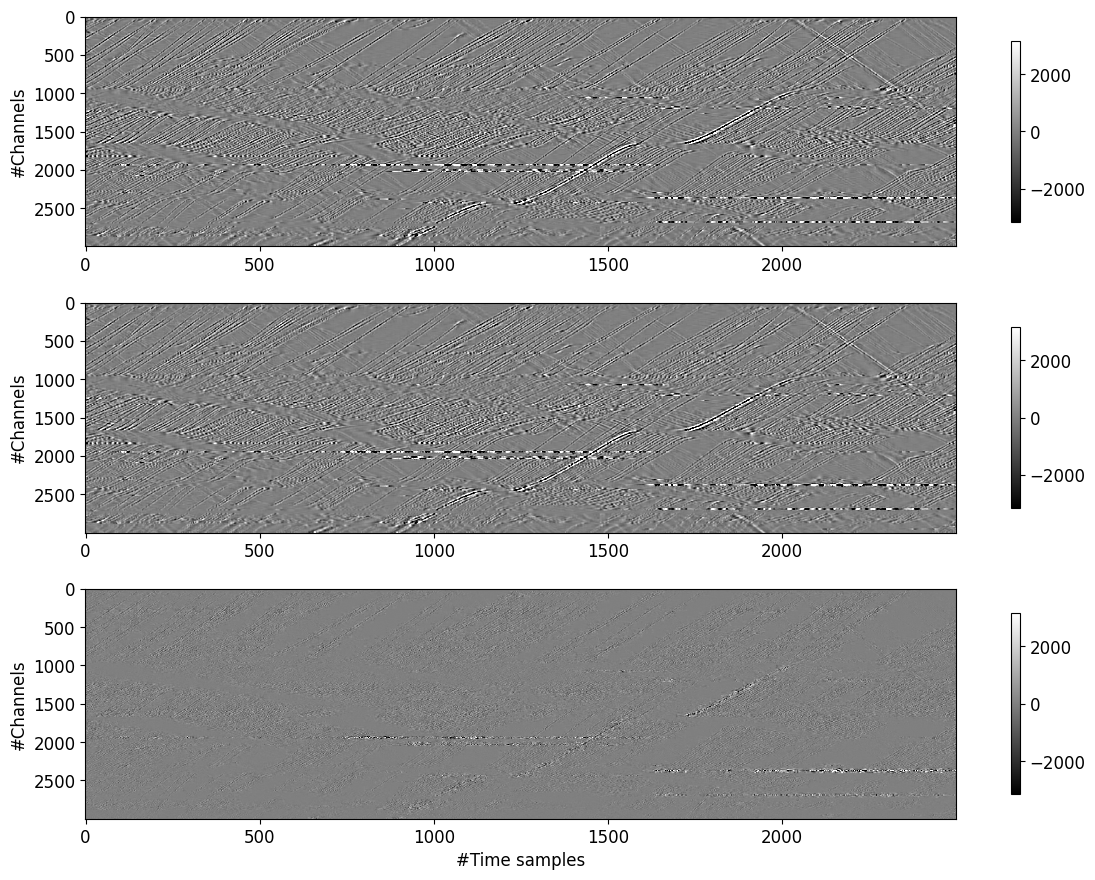

In [17]:
plt.figure(figsize=(12, 9))
plt.rcParams.update({'font.size': 12})


nt = 2500
nc = 3000
aspect = 0.22

relloss = np.sum(np.abs(original_das - decompre_das))/np.sum(np.abs(original_das))

plt.subplot(311)
pclip = np.percentile(original_das, 99.)
plt.imshow(original_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
# plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Original DAS')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.subplot(312)
plt.imshow(decompre_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
# plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Reconstructed DAS')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.subplot(313)
plt.imshow(original_das[:nc, :nt] - decompre_das[:nc, :nt], cmap='gray', aspect=aspect, vmin=-pclip, vmax=pclip)
plt.xlabel('#Time samples')
plt.ylabel('#Channels')
# plt.title('Difference')
# plt.colorbar(orientation="horizontal",fraction=0.07)
plt.colorbar(shrink=0.75)

plt.tight_layout()